In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats

#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from sklearn.mixture import GaussianMixture 
#import testing
import sys
sys.path.append("../")
import selection_tests

import itertools

In [2]:
data = pd.read_stata("all_plans_c_bonus.dta")
data['log_enroll'] = np.log(data['enr_c'])
data['enr_total'] = data['enr_c'] + data['enr_FFS']

#create a variable that is just db 
treat = data[['ssa', 'state', 'county', 'double_bonus']].copy()
treat = treat.groupby(['ssa', 'state', 'county'],as_index=False).max()
treat = treat.rename(columns={'double_bonus':'treatment' })


print(treat)
print(data.shape)
data = data.merge(treat, on=['ssa', 'state', 'county'],how='left')
print(data.shape)
print(data[data['year'] == 2016]['treatment'].mean())
print(data[ data['year'] == 2016 ]['double_bonus'].mean())
print(data[ data['year'] == 2012 ]['double_bonus'].mean())
print(data[data['year']==2006]['treatment'].max())
print(data[data['year']==2012]['treatment'].max())

        ssa state      county  treatment
0      1000    AL     Autauga          1
1      1010    AL     Baldwin          1
2      1020    AL     Barbour          0
3      1030    AL        Bibb          1
4      1040    AL      Blount          1
...     ...   ...         ...        ...
2966  53180    WY  Sweetwater          0
2967  53190    WY       Teton          0
2968  53200    WY       Uinta          0
2969  53210    WY    Washakie          0
2970  53220    WY      Weston          0

[2971 rows x 4 columns]
(32702, 82)
(32702, 83)
0.09527410207939509
0.0892249527410208
0.07532281205164992
1
1


-483.1849888392858


/tmp/ipykernel_14907/4278849082.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff
/tmp/ipykernel_14907/4278849082.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + trend_adj


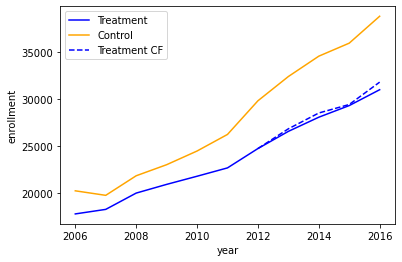

(    year      enr_c   enr_total  treatment             y
 0   2006  3017622.0  25179618.0          0  20209.921875
 1   2007  3315265.0  26031686.0          0  19727.857422
 2   2008  4039823.0  26609852.0          0  21813.353516
 3   2009  4358486.0  26945392.0          0  22992.107422
 4   2010  4598920.0  27459440.0          0  24450.519531
 5   2011  4758777.0  27899786.0          0  26217.652344
 6   2012  5274290.0  28875432.0          0  29803.156250
 7   2013  5738758.0  29670032.0          0  32388.714844
 8   2014  6091955.0  29868524.0          0  34557.984375
 9   2015  6537662.0  35193808.0          0  35946.679688
 10  2016  6941128.0  36045652.0          0  38814.378906,
     year      enr_c   enr_total             y
 0   2006  1830541.0   7252935.0  17748.046875
 1   2007  1951769.0   7374281.0  18231.066406
 2   2008  2193914.0   7319448.0  19967.642578
 3   2009  2323885.0   7391350.0  20894.748047
 4   2010  2447180.0   7533377.0  21762.593750
 5   2011  2556895.0 

In [10]:
def create_plot_y(df):
    df = df.copy()
    df['y'] = df['enr_c']*df['enr_total']
    df_group = df.groupby('year',as_index=False).sum()
    df_group['y'] = df_group['y']/df_group['enr_total']
    return df_group.copy()


def create_synth_plot(data,intervention,begin,end,name):    
    #treatment
    data_treat = data[(data['treatment']==1) & (data['year'] >= begin) &
                              (data['year'] <= end) ][['enr_c','year','enr_total']]
    data_treat =  create_plot_y(data_treat)
    plt.plot(data_treat['year'],data_treat['y'],label='Treatment',color='blue')

    
    #control
    data_control  = data[ (data['treatment']==0) & (data['year'] >= begin) &
                              (data['year'] <= end) ][['enr_c','year','enr_total','treatment']]
    data_control =  create_plot_y(data_control)
    plt.plot(data_control['year'],data_control['y'],label='Control',color='orange')
    

    #treat cf
    data_treat_cf = data_control[ (data_control['year']>=intervention) & (data_control['year']<=end)]
    diff = (data_treat['y'][data_treat['year']==intervention].mean() - 
                data_control['y'][data_control['year']==intervention].mean())
    data_treat_cf['y'] = data_treat_cf['y'] + diff
    
    
    #estimate pre-period trends (could do this with linear projection instead)
    trend_treat = np.zeros(intervention-begin+1)
    trend_control = np.zeros(intervention-begin+1)
    
    for year in range(begin,intervention+1):
        trend_treat[year-begin] = (data_treat['y'][data['year']==year+1].max() - 
                                data_treat['y'][data['year']==year].max())
        
        trend_control[year-begin] = (data_control['y'][data['year']==year+1].max() -
                                  data_control['y'][data['year']==year].max())
    #readjust the cf by the trend...
    trend_adj = (trend_treat.mean() - trend_control.mean())*np.arange(0,end-intervention+1)
    print((trend_treat.mean() - trend_control.mean()))
    trend_adj =pd.Series(trend_adj,index=range(intervention-begin,end-begin+1))
    data_treat_cf['y'] = data_treat_cf['y'] + trend_adj
    
    plt.plot(data_treat_cf['year'],data_treat_cf['y'],label='Treatment CF',color='blue',linestyle='--')

    plt.xlabel('year')
    plt.ylabel('enrollment')
    plt.legend()
    plt.savefig(name,dpi=300)
    plt.show()
    return data_control, data_treat, data_treat_cf
    
create_synth_plot(data,2012,2006,2016,'double_bonus_intervention.png')

nan


/tmp/ipykernel_14907/4278849082.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff
/tmp/ipykernel_14907/4278849082.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + trend_adj


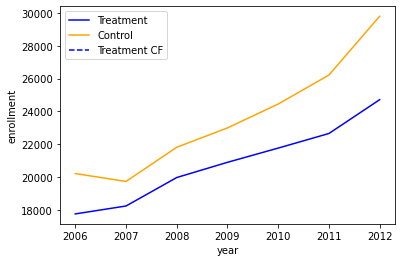

(   year      enr_c   enr_total  treatment             y
 0  2006  3017622.0  25179618.0          0  20209.921875
 1  2007  3315265.0  26031686.0          0  19727.857422
 2  2008  4039823.0  26609852.0          0  21813.353516
 3  2009  4358486.0  26945392.0          0  22992.107422
 4  2010  4598920.0  27459440.0          0  24450.519531
 5  2011  4758777.0  27899786.0          0  26217.652344
 6  2012  5274290.0  28875432.0          0  29803.156250,
    year      enr_c  enr_total             y
 0  2006  1830541.0  7252935.0  17748.046875
 1  2007  1951769.0  7374281.0  18231.066406
 2  2008  2193914.0  7319448.0  19967.642578
 3  2009  2323885.0  7391350.0  20894.748047
 4  2010  2447180.0  7533377.0  21762.593750
 5  2011  2556895.0  7695250.0  22652.478516
 6  2012  2790350.0  8040747.0  24713.785156,
    year      enr_c   enr_total  treatment   y
 6  2012  5274290.0  28875432.0          0 NaN)

In [12]:
create_synth_plot(data,2012,2006,2012,'double_bonus_intervention-zoom.png')

In [5]:
print(data['bm_ns'].mean())
print(data['bmFFS'].mean())
print(data['benchmark_diff_ns'].mean())
print(data['bm_ns']-data['bmFFS'])

818.4683227539062
829.761474609375
-5.740026950836182
0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
32697   -58.529480
32698   -37.839966
32699     0.000000
32700     0.000000
32701     0.000000
Length: 32702, dtype: float32


In [6]:
cutoff1 = 5
cutoff2 = 3

#make a new treatment var...
data_bm = data.copy()
data_bm = data_bm.drop(['treatment'],axis=1)

treat = data[['ssa', 'state', 'county', 'bm_ns']].copy()
treat_2011 = data[['ssa', 'state', 'county', 'bm_ns']][data['year']==2011]
treat_2011 = treat_2011.groupby(['ssa', 'state', 'county'],as_index=False).max()

treat_2012 = data[['ssa', 'state', 'county', 'bm_ns']][data['year']==2012]
treat_2012 = treat_2012.groupby(['ssa', 'state', 'county'],as_index=False).max()


treat_2012_2 = data[['ssa', 'state', 'county', 'bmFFS']][data['year']==2012]
treat_2012_2 = treat_2012_2.groupby(['ssa', 'state', 'county'],as_index=False).max()

treat = treat_2011.merge(treat_2012,on=['ssa', 'state', 'county'],suffixes=('_2011', '_2012'))
treat = treat.merge(treat_2012_2,on=['ssa', 'state', 'county'])




print(data_bm.shape)
data_bm = data_bm.merge(treat, on=['ssa', 'state', 'county'],how='left',suffixes=('','_2012'))
print(data_bm.shape)

data_bm['treatment_1'] = 100*(data_bm['bm_ns_2011'] - data_bm['bm_ns_2012'])/data_bm['bm_ns_2011'] 
data_bm['treatment_2'] = 100*(data_bm['bmFFS_2012'] - data_bm['bm_ns_2012'])/data_bm['bm_ns_2012'] 
data_bm['treatment'] =  (data_bm['treatment_1'] > cutoff1 )*(data_bm['treatment_2'] < cutoff2)
#data_bm['treatment_1']  + 2 >= data_bm['treatment_2'] 
print(data_bm[['bm_ns_2011','bm_ns_2012','bmFFS_2012','treatment_1','treatment_2','treatment']])

#bm 5_star with some percent of bm cut

(32702, 82)
(32702, 85)
       bm_ns_2011  bm_ns_2012  bmFFS_2012  treatment_1  treatment_2  treatment
0      863.221558  810.012573  824.830750     6.164001     1.829376       True
1      863.221558  810.012573  824.830750     6.164001     1.829376       True
2      863.221558  810.012573  824.830750     6.164001     1.829376       True
3      863.221558  810.012573  824.830750     6.164001     1.829376       True
4      863.221558  810.012573  824.830750     6.164001     1.829376       True
...           ...         ...         ...          ...          ...        ...
32697  781.972595  756.370239  778.278259     3.274073     2.896468      False
32698  781.972595  756.370239  778.278259     3.274073     2.896468      False
32699  781.972595  756.370239  778.278259     3.274073     2.896468      False
32700  781.972595  756.370239  778.278259     3.274073     2.896468      False
32701  781.972595  756.370239  778.278259     3.274073     2.896468      False

[32702 rows x 6 columns]


/tmp/ipykernel_14907/584154762.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff
/tmp/ipykernel_14907/584154762.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + trend_adj


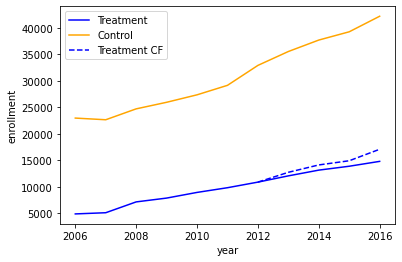

0      4893.696777
1      5117.924316
2      7162.795898
3      7882.931641
4      8953.720703
5      9841.081055
6     10897.531250
7     12078.378906
8     13162.188477
9     13896.738281
10    14815.288086
Name: y, dtype: float32


In [7]:
data_control, data_treat, data_treat_cf = create_synth_plot(data_bm,2012,2006,2016,'bm_cuts_intervention.png')

print(data_treat['y'])